# Camera Intrinsic Calibration

In this notebook we will:
1. Load the detected corner data from `captured_points/corners.npz`.
2. Run either checkerboard or ChArUco calibration.
3. Examine and plot reprojection errors.
4. Save the resulting camera matrix **K** and distortion coefficients **d** to `captured_points/intrinsics.yml`.

In [2]:
import numpy as np
import cv2
import yaml
import os
import matplotlib.pyplot as plt

# Make plots appear inline
%matplotlib inline

# Paths (relative to notebook location)
DATA_DIR = os.path.join('..', 'captured_points')
NPZ_FILE = os.path.join(DATA_DIR, 'corners.npz')
YAML_OUT = os.path.join(DATA_DIR, 'intrinsics.yml')

print("Corners file:", NPZ_FILE)

Corners file: ../captured_points/corners.npz


In [3]:
data = np.load(NPZ_FILE, allow_pickle=True)
print("Keys in NPZ:", list(data.keys()))

# Determine calibration mode
if 'objpoints' in data:
    mode = 'checker'
elif 'corners' in data:
    mode = 'charuco'
else:
    raise ValueError("Unrecognized data format in corners.npz")
print(f"Calibration mode: {mode}")

Keys in NPZ: ['valid_files', 'objpoints', 'imgpoints', 'img_shape']
Calibration mode: checker


Recall the forward projection

$$
\underbrace{\begin{bmatrix}u\\v\\1\end{bmatrix}}_{\text{pixel}}
=
\underbrace{
\begin{bmatrix}
f_x & 0   & c_x\\
0   & f_y & c_y\\
0   & 0   & 1
\end{bmatrix}}_{K}
\Bigl(1 + \text{distort}(\mathbf{x}_n)\Bigr)
\underbrace{\frac{1}{Z_c}
\begin{bmatrix}
X_c\\Y_c\\1
\end{bmatrix}}_{\mathbf{x}_n}
$$

*We'll estimate $K$ and the distortion parameters by minimising the reprojection error $e_i = \lVert x_i - \hat{x}_i\rVert$.*

OpenCV provides highly optimized functions for camera calibration. The `cv2.calibrateCamera()` function (for checkerboards) and `cv2.aruco.calibrateCameraCharuco()` function (for ChArUco boards) use nonlinear optimization to find the camera matrix $K$ and distortion coefficients that minimize the reprojection error across all calibration frames.

The code below performs camera calibration using either:
1. Standard checkerboard calibration (using `cv2.calibrateCamera()`)
2. ChArUco board calibration (using `cv2.aruco.calibrateCameraCharuco()`)

The calibration returns:
- `ret`: Mean reprojection error in pixels (lower is better)
- `K`: The 3×3 camera intrinsic matrix
- `dist`: Distortion coefficients (k₁, k₂, p₁, p₂, k₃, ...)
- `rvecs`, `tvecs`: Rotation and translation vectors for each calibration frame

In [4]:
# Retrieve common items
img_shape = tuple(data['img_shape'])  # (width, height)

if mode == 'checker':
    objpoints = data['objpoints']
    imgpoints = data['imgpoints']
    ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, imgpoints, img_shape, None, None
    )
elif mode == 'charuco':
    corners = data['corners']
    ids     = data['ids']
    # recreate the board definition exactly as in detect_corners.py
    aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
    board = cv2.aruco.CharucoBoard_create(5, 7, 0.03, 0.022, aruco_dict)
    ret, K, dist, rvecs, tvecs = cv2.aruco.calibrateCameraCharuco(
        corners, ids, board, img_shape, None, None
    )

print(f"Mean reprojection error: {ret:.4f} px")
print("Camera matrix K:\n", K)
print("Distortion coeffs d:\n", dist.ravel())

Mean reprojection error: 0.3595 px
Camera matrix K:
 [[1.32822187e+03 0.00000000e+00 3.86057040e+02]
 [0.00000000e+00 1.31556306e+03 1.91747852e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coeffs d:
 [ 0.09735931  1.09243376 -0.01720673  0.0285858  -4.75492899]


Total points: 594, mean error = 0.3001 px


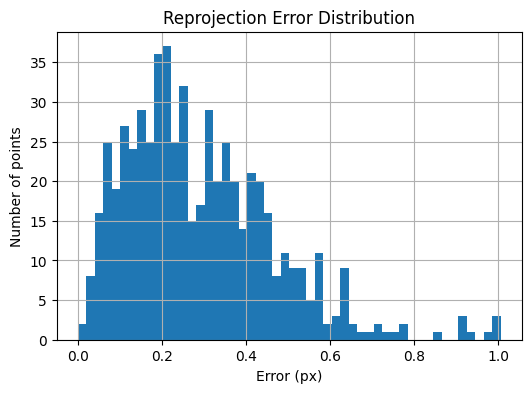

In [5]:
errors = []

if mode == 'checker':
    # project each object point into the image
    for objp, imgp, rvec, tvec in zip(objpoints, imgpoints, rvecs, tvecs):
        proj, _ = cv2.projectPoints(objp, rvec, tvec, K, dist)
        err = np.linalg.norm(proj.reshape(-1,2) - imgp.reshape(-1,2), axis=1)
        errors.extend(err)
elif mode == 'charuco':
    # project all ChArUco corners
    for ch_corners, ch_ids, rvec, tvec in zip(corners, ids, rvecs, tvecs):
        proj, _ = cv2.projectPoints(ch_corners, rvec, tvec, K, dist)
        err = np.linalg.norm(proj.reshape(-1,2) - ch_corners.reshape(-1,2), axis=1)
        errors.extend(err)

errors = np.array(errors)
print(f"Total points: {len(errors)}, mean error = {errors.mean():.4f} px")

plt.figure(figsize=(6,4))
plt.hist(errors, bins=50, range=(0, np.percentile(errors,99)))
plt.title("Reprojection Error Distribution")
plt.xlabel("Error (px)")
plt.ylabel("Number of points")
plt.grid(True)
plt.show()

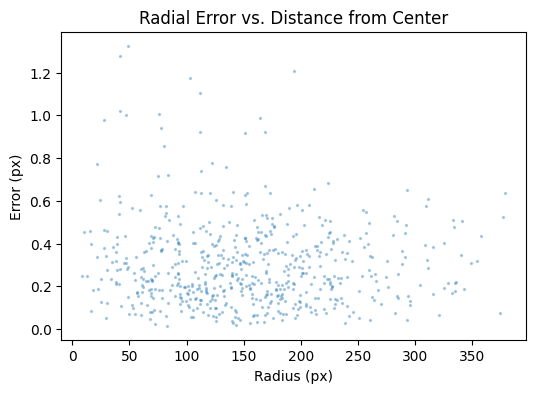

In [6]:
# Gather radial distances and corresponding errors
radial = []
for fname in []: pass  # placeholder; we can reuse corners or compute directly

# Instead, recompute radial distances from principal point:
cx, cy = K[0,2], K[1,2]
pts = []
errs = []
if mode == 'checker':
    for objp, imgp, rvec, tvec in zip(objpoints, imgpoints, rvecs, tvecs):
        proj, _ = cv2.projectPoints(objp, rvec, tvec, K, dist)
        flat_proj = proj.reshape(-1,2)
        flat_imgp = imgp.reshape(-1,2)
        for p_proj, p_img in zip(flat_proj, flat_imgp):
            radial.append(np.linalg.norm(p_img - np.array([cx, cy])))
            errs.append(np.linalg.norm(p_proj - p_img))
elif mode == 'charuco':
    for ch_corners, rvec, tvec in zip(corners, rvecs, tvecs):
        proj, _ = cv2.projectPoints(ch_corners, rvec, tvec, K, dist)
        flat_proj = proj.reshape(-1,2)
        flat_corn = ch_corners.reshape(-1,2)
        for p_proj, p_corn in zip(flat_proj, flat_corn):
            radial.append(np.linalg.norm(p_corn - np.array([cx, cy])))
            errs.append(np.linalg.norm(p_proj - p_corn))

radial = np.array(radial)
errs   = np.array(errs)

plt.figure(figsize=(6,4))
plt.scatter(radial, errs, s=2, alpha=0.3)
plt.title("Radial Error vs. Distance from Center")
plt.xlabel("Radius (px)")
plt.ylabel("Error (px)")
plt.show()

In [7]:
calib = {
    'K': {'data': K.tolist(), 'rows':3, 'cols':3},
    'D': {'data': dist.ravel().tolist(), 'rows':1, 'cols':len(dist.ravel())}
}
with open(YAML_OUT, 'w') as f:
    yaml.dump(calib, f)
print(f"Saved intrinsics to {YAML_OUT}")

Saved intrinsics to ../captured_points/intrinsics.yml


## Overlay: Detected vs. Reprojected Corners

Now that we have our camera matrix **K** and distortion **d**, let's take one example image and:

1. Plot the **detected** corners in **green**.  
2. Project the corresponding 3D object points back into the image and plot these **reprojected** corners in **red**.  

Ideally they should coincide. Large offsets highlight local calibration errors.

(-0.5, 639.5, 479.5, -0.5)

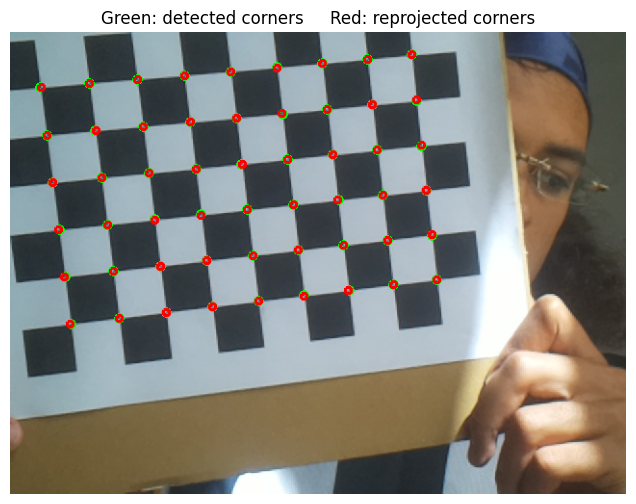

In [8]:
# pick the middle image for visualization
img_files = sorted(os.path.join('..','data',f) for f in os.listdir('../data') if f.endswith('.jpg'))
valid_files = data['valid_files']
img_idx = len(valid_files)//3
viz_path = valid_files[img_idx]
viz_img = cv2.imread(os.path.join('..','data', os.path.basename(viz_path)))
gray_viz = cv2.cvtColor(viz_img, cv2.COLOR_BGR2GRAY)

# retrieve one set of object & image points for checkerboard, or charuco
if mode == 'checker':
    objp = objpoints[img_idx]         # 3D points
    imgp = imgpoints[img_idx].reshape(-1,2)  # detected 2D points
    rvec, tvec = rvecs[img_idx], tvecs[img_idx]
elif mode == 'charuco':
    # convert to 3D by adding Z=0
    ch_c = corners[img_idx].reshape(-1,2)
    objp = np.hstack([ch_c, np.zeros((len(ch_c),1))])
    imgp = ch_c
    rvec, tvec = rvecs[img_idx], tvecs[img_idx]

# project objp back into pixel space
proj_pts, _ = cv2.projectPoints(objp, rvec, tvec, K, dist)
proj_pts = proj_pts.reshape(-1,2)

# overlay
vis = viz_img.copy()
for (x,y), (u,v) in zip(imgp, proj_pts):
    cv2.circle(vis, (int(x),int(y)), 4, (0,255,0), 2)  # green = detected
    cv2.circle(vis, (int(u),int(v)), 3, (0,0,255), 2)  # red   = reprojected

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("Green: detected corners     Red: reprojected corners")
plt.axis('off')

## What Are We Comparing Between Green and Red Dots?

This visualization shows two sets of 2D points plotted over the image:

- **Green dots**: These are **detected image points** — pixel locations where the checkerboard corners were found using OpenCV's `findChessboardCorners()` (or ChArUco equivalent). These are your "ground truth" 2D detections.
- **Red dots**: These are **reprojected points** — predicted pixel positions obtained by projecting the known 3D board corners using your estimated camera intrinsics and extrinsics. These come from `cv2.projectPoints()`.

---

### Step-by-Step Pipeline

#### 1. **Detect corners in the image (green dots)**

You detect 2D points in the captured image using:
```python
ret, corners = cv2.findChessboardCorners(gray, pattern_size, ...)
```

This gives you a list of 2D image coordinates:
$$\{(u_i, v_i)\}_{i=1}^{N}$$

#### 2. **Define the known 3D object points**

For a checkerboard with num_x × num_y squares, there are (num_x - 1) × (num_y - 1) inner corners. We define these points on a 2D plane (Z = 0), scaled by the square size:
$$\{(X_i, Y_i, 0)\}_{i=1}^{N}$$

#### 3. **Calibrate the camera**

You solve for the camera intrinsics (K), distortion coefficients (d), and per-frame extrinsics (R, t) using:

```python
cv2.calibrateCamera(...)
```

This fits the projection model:
$$\mathbf{P} = \mathbf{K} [\mathbf{R} \mid \mathbf{t}]$$
and distortion model (radial + tangential) by minimizing:
$$\sum_{i} \left| (u_i, v_i) - \Pi(\mathbf{K}, \mathbf{R}, \mathbf{t}; X_i) \right|^2$$

#### 4. **Reproject the 3D points into image space (red dots)**

Using the estimated calibration parameters, you reproject the known 3D object points into the image:

```python
proj_pts = cv2.projectPoints(objp, rvec, tvec, K, dist)
```

This yields predicted 2D points:
$$\{(\hat{u}_i, \hat{v}_i)\}_{i=1}^{N}$$

---

### Why Are the Red and Green Dots Different?

They won't perfectly overlap, because the model is an approximation and the input data is noisy:
- **Detection noise**: Even subpixel corner detection is affected by blur, lighting, and resolution.
- **Model mismatch**: The distortion model may not fully capture the lens behavior, especially at the periphery.
- **Limited coverage**: If certain viewpoints (e.g. tilted, close-up, or edge shots) are missing, the model is under-constrained in those areas.
- **Numerical approximation**: Optimization has residual error even after convergence.

---

### Reprojection Error

The difference between red and green dots is called the reprojection error — the distance between where the model says a corner should be and where it was actually detected.
- **Good calibration**: < 0.5 px mean reprojection error
- **Precision calibration**: < 0.3 px
- **Bad calibration**: > 1.0 px — likely poor data, blur, or mismatch in square size or pattern

---

### How to Improve Alignment
- **Ensure accurate board specs**: match pattern_size to the printed board.
- **Use consistent indexing**: Make sure you're overlaying red/green dots for the same image.
- **Capture diverse viewpoints**: Boards at various angles, distances, and edge positions.
- **Drop outlier images**: Recompute calibration without frames that have large reprojection error.

## Try-it-yourself ✏️  
Use the sliders below to perturb the **radial (k₁, k₂)** and **tangential (p₁, p₂)** distortion
coefficients and watch how the *red* re-projected corners shift relative to the *green*
detected ones.

* Questions to think about  
  1. When you nudge **k₁** positively, which image region moves the most?  
  2. Which coefficient mainly shears the pattern rather than radial-expands it?  
  3. At what coefficient values do the re-projected dots best coincide with the detections?  

Remember: in a real calibration workflow we optimise these coefficients so that the
re-projection error (pixel distance between the two sets of dots) is minimised.

In [26]:
! pip install ipywidgets
import ipywidgets as widgets
from ipywidgets import interactive, HBox, VBox, Button
import matplotlib.pyplot as plt
import cv2
import numpy as np

# --- objects prepared earlier -----------------
# K, dist, objp, imgp, rvec, tvec, viz_img
# ---------------------------------------------

# ❶ Create the sliders

def make_slider(label, value, coarse_factor=3.0, fine_step=1e-3,
                hard_max=5.0):
    """
    Return a FloatSlider centred at 0 whose ±range equals
    min(hard_max, coarse_factor*|value|) but never < 0.05.
    """
    span = max(abs(value) * coarse_factor, 0.05)
    span = min(span, hard_max)
    return widgets.FloatSlider(
        value=float(value),
        min=-span,
        max= span,
        step=fine_step,
        description=label
    )

# 1️⃣ Sliders for all five coefficients
k1_slider = make_slider('k₁', dist[0][0])
k2_slider = make_slider('k₂', dist[0][1])
p1_slider = make_slider('p₁', dist[0][2], coarse_factor=3.0, fine_step=1e-4, hard_max=0.2)
p2_slider = make_slider('p₂', dist[0][3], coarse_factor=3.0, fine_step=1e-4, hard_max=0.2)
k3_slider = make_slider('k₃', dist[0][4], coarse_factor=1.5, fine_step=1e-2, hard_max=10)

# 2️⃣ Reset button
reset_btn = Button(description="Reset ↺", tooltip="Restore calibrated values")

def reset_sliders(_):
    for s, val in zip([k1_slider, k2_slider, p1_slider, p2_slider, k3_slider], dist[0]):
        s.value = float(val)
reset_btn.on_click(reset_sliders)

# 3️⃣ Projection visualisation
def show_projection(k1, k2, p1, p2, k3):
    d = np.array([k1, k2, p1, p2, k3], dtype=np.float64)
    proj_pts, _ = cv2.projectPoints(objp, rvec, tvec, K, d)
    proj_pts = proj_pts.reshape(-1, 2)

    vis = viz_img.copy()
    for (x, y), (u, v) in zip(imgp, proj_pts):
        cv2.circle(vis, (int(x), int(y)), 4, (0, 255, 0), 2)   # detected
        cv2.circle(vis, (int(u), int(v)), 3, (0,   0, 255), 2) # re-projected

    plt.figure(figsize=(6, 5))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# 4️⃣ Bind sliders to plotting function
interactive_plot = interactive(
    show_projection,
    k1=k1_slider, k2=k2_slider, k3=k3_slider,
    p1=p1_slider, p2=p2_slider
)

# 5️⃣ Display UI
display(VBox([HBox([reset_btn]), interactive_plot]))


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### What do the distortion coefficients actually do?

| Symbol | Name | Typical visual effect  |
| ------ | ---- | ---------------------  |
| **k₁** | 1st radial distortion | Barrel / pincushion curvature that grows ∝ *r²* |
| **k₂** | 2nd radial distortion | Higher-order tweak that exaggerates the edge warping introduced by **k₁** |
| **k₃** | 3rd radial distortion | Cubic radial term—dominates in the extreme corners when **k₁**, **k₂** can’t fully correct |
| **p₁** | Tangential (x-shear) | Skews dots left/right when the lens & sensor are not perfectly parallel |
| **p₂** | Tangential (y-shear) | Skews dots up/down under the same mis-alignment |

*Here \(r^2 = x^2 + y^2\) is the squared, normalised image-plane radius.*

**How to interpret the sliders**

* If the red dots form a symmetric bulge or pinch, adjust **k₁**, **k₂**, or **k₃** (radial terms).  
* If they lean or shear in one direction, tweak **p₁** or **p₂** (tangential terms).  
* Press **Reset ↺** any time to return to the calibrated optimum.

## Side-by-side: Original vs. Undistorted

Next, we’ll undistort the same image using our intrinsics and plot it alongside the original.  
Notice how straight lines near the border are “pulled” back into alignment.

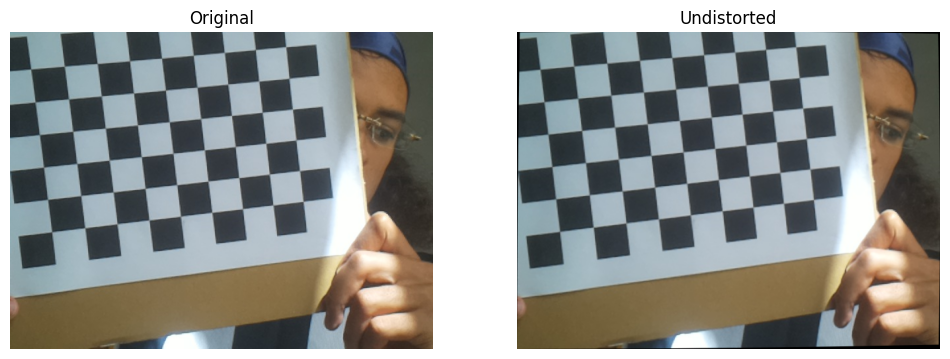

In [10]:
# undistort entire image
h, w = gray_viz.shape
newK, _ = cv2.getOptimalNewCameraMatrix(K, dist, (w,h), 1)
undist = cv2.undistort(viz_img, K, dist, None, newK)

# plot side by side
fig, axes = plt.subplots(1,2, figsize=(12,5))
axes[0].imshow(cv2.cvtColor(viz_img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis('off')
axes[1].imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
axes[1].set_title("Undistorted")
axes[1].axis('off')
plt.show()

## Distortion Vector Field

Let’s visualize how each pixel is displaced by the distortion model.  
We’ll sample a coarse grid (e.g. every 40 px), undistort those points,  
and draw arrows from original → undistorted positions.

(-0.5, 639.5, 479.5, -0.5)

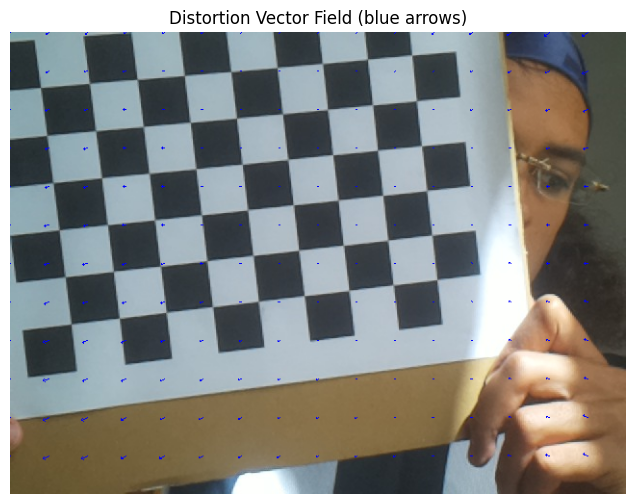

In [11]:
# create grid of points
stride = 40
Y, X = np.mgrid[0:h:stride, 0:w:stride].reshape(2,-1)
grid = np.vstack([X, Y]).T.astype(np.float32).reshape(-1,1,2)

# undistort these grid points
und_grid = cv2.undistortPoints(grid, K, dist, P=K).reshape(-1,2)

# plot arrows on the original image
field_vis = viz_img.copy()
for (x,y), (u,v) in zip(grid.reshape(-1,2), und_grid):
    cv2.arrowedLine(field_vis, (int(x),int(y)), (int(u),int(v)),
                    color=(255,0,0), thickness=1, tipLength=0.3)

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(field_vis, cv2.COLOR_BGR2RGB))
plt.title("Distortion Vector Field (blue arrows)")
plt.axis('off')

*The arrows indicate the magnitude and direction of distortion across the field—longer arrows at the periphery reflect stronger barrel distortion.*

## Error Heatmap Across All Images

Finally, let’s accumulate reprojection errors spatially over every image.  
We’ll bin each projected point by its undistorted pixel location and color‐code the average error in each bin.

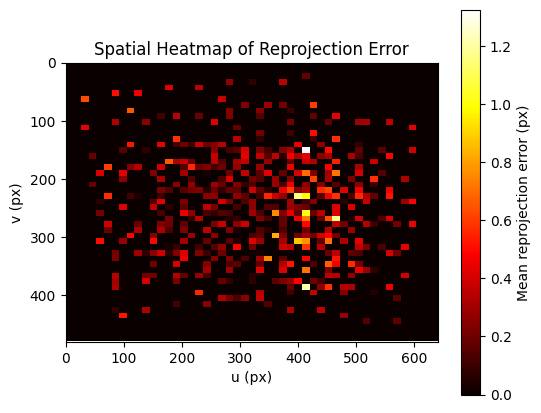

In [12]:
# gather all reproj errors + undistorted locations
all_u = []; all_v = []; all_e = []

for i in range(len(rvecs)):
    if mode == 'checker':
        pts2d = imgpoints[i].reshape(-1,2)
        objp_i = objpoints[i]
    else:
        pts2d = corners[i].reshape(-1,2)
        objp_i = np.hstack([pts2d, np.zeros((len(pts2d),1))])

    # project and undistort
    proj2d, _ = cv2.projectPoints(objp_i, rvecs[i], tvecs[i], K, dist)
    proj2d = proj2d.reshape(-1,2)
    und2d = cv2.undistortPoints(pts2d.reshape(-1,1,2), K, dist, P=K).reshape(-1,2)

    errs = np.linalg.norm(proj2d - pts2d, axis=1)
    all_u.extend(und2d[:,0]); all_v.extend(und2d[:,1]); all_e.extend(errs)

all_u = np.array(all_u); all_v = np.array(all_v); all_e = np.array(all_e)

# bin into a heatmap
nbin = 50
xi = np.linspace(0, w, nbin)
yi = np.linspace(0, h, nbin)
heatmap, _, _ = np.histogram2d(all_v, all_u, bins=[yi, xi], weights=all_e)
counts, _, _  = np.histogram2d(all_v, all_u, bins=[yi, xi])
heatmap = np.divide(heatmap, counts, out=np.zeros_like(heatmap), where=counts>0)

plt.figure(figsize=(6,5))
plt.imshow(heatmap, origin='lower', extent=[0,w,0,h], cmap='hot')
plt.colorbar(label='Mean reprojection error (px)')
plt.title("Spatial Heatmap of Reprojection Error")
plt.xlabel("u (px)"); plt.ylabel("v (px)")
plt.gca().invert_yaxis()
plt.show()

*The heatmap shows where your calibration struggles most; hot regions near the border often point to insufficient distortion modeling or corner detection accuracy.*

---

**Next:**  
- Use these intrinsics in `measure_object.py` to perform metric checks.  
- Switch to the other board type (checker ↔ ChArUco) and compare mean errors.  
- Commit `captured_points/intrinsics.yml` to GitHub for TA review.